In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from model import InvertedPendulum, massSpringDamper

In [4]:
class PID_controller():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd

    def action(self, error, errorDot, errorInt):
        return self.kp*error + self.ki*errorInt + self.kd*errorDot
    
class stateFeedback_controller():
    def __init__(self, gain):
        self.gain = gain
    
    def action(self, state):
        return np.dot(self.gain, state)
    

In [108]:
def main():
    m_msd = 1
    c_msd = 1
    k_msd = 1
    m_ivp = 1
    k_ivp = 1
    l_ivp = 1
    g = 9.8

    mass_spring_damper = massSpringDamper(m_msd, c_msd, k_msd)

    inverted_pendulum = InvertedPendulum(m_ivp, l_ivp, g, k_ivp)

    pid_controller = PID_controller(10,5,0)

    sim_time = 10

    sim_dt = 0.05
    
    theta_0 = 10*np.pi/180
    theta_T = (2/3)*np.pi
    omega_0, omega_T = 0,0

    #implementing PID
    error_p = 0
    theta = theta_0
    omega = omega_0
    theta_array = [theta]
    omega_array = [omega]
    error_int = 0
    time_array = [0]
    u_pid_array = []
    error_array = []
    for time in np.arange(0, sim_time, sim_dt):
        error = theta_T - theta
        error_dot = (error - error_p)/sim_dt
        error_int += error*sim_dt
        u_pid = pid_controller.action(error, error_dot, error_int)
        theta_next, omega_next = inverted_pendulum.nextState([theta, omega], u_pid, sim_dt)
        theta, omega = theta_next, omega_next
        theta_array.append(theta)
        omega_array.append(omega)
        time_array.append(time+sim_dt)
        u_pid_array.append(u_pid)
        error_array.append(error)

    plt.figure(1)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, theta_array)
    ax1.title.set_text('theta')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array, omega_array)
    ax2.title.set_text('omega')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:-1], u_pid_array)
    ax3.title.set_text('control')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:-1], error_array)
    ax4.title.set_text('error')

    #implementing state feedback assuming full state is available

    x_T = np.array([[theta_T],[omega_T]])
    x_0 = np.array([[theta_0],[omega_0]])
    omega_array_sf = [omega_0]
    theta_array_sf = [theta_0]
    #x_array_sf = [x_0]
    x_array_sf = np.zeros((2, int(sim_time/sim_dt+1)))
    x_array_sf[0,0] = x_0[0,0]
    x_array_sf[1,0] = x_0[1,0]
    u_sf_array = []
    error_sf_array = []
    x = np.copy(x_0)
    for time in np.arange(0, sim_time, sim_dt):
        A_mat = inverted_pendulum.AMatt(x[0,0])
        B_mat = inverted_pendulum.BMatt()
        poles = np.array([-10,-25])
        K_mat = sc.signal.place_poles(A_mat, B_mat, poles).gain_matrix
        u_ss = inverted_pendulum.m*g*inverted_pendulum.l/2*np.cos(x[0,0])*(x_T[0,0] - x[0,0])
        #print('u_ss - ', u_ss, 'K_mat - ',  K_mat, 'diff - ', x_T - x)
        u_tot = u_ss + np.dot(K_mat,(x_T - x))[0,0]
        # print('mat prod', np.dot(K_mat,(x_T - x))[0,0])
        # print('u_tot', u_tot[0, 0])
        
        theta_next, omega_next = inverted_pendulum.nextState([x[0,0], x[1,0]], u_tot, sim_dt)
        theta_array_sf.append(theta_next)
        omega_array_sf.append(omega_next)
        u_sf_array.append(u_tot)
        error_sf_array.append(theta_T - theta_next)
        if theta_next == 0:
            print('fuck')
        x = np.array([[theta_next], [omega_next]])
        if x[0,0] == 0:
            print('wtf')
        #print(int(time/sim_dt + 1))
        x_array_sf[0,int(time/sim_dt + 1)] = x[0,0]
        x_array_sf[1,int(time/sim_dt + 1)] = x[1,0]    
        #x_array_sf.append(x)
    #print('theta_sf', x_array_sf[0,:])
    plt.figure(2)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, theta_array_sf)
    ax1.title.set_text('theta')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array,  omega_array_sf)
    ax2.title.set_text('omega')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:-1], u_sf_array)
    ax3.title.set_text('control')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:-1], error_sf_array)
    ax4.title.set_text('error')


    
        
        

    

C:\Users\karan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


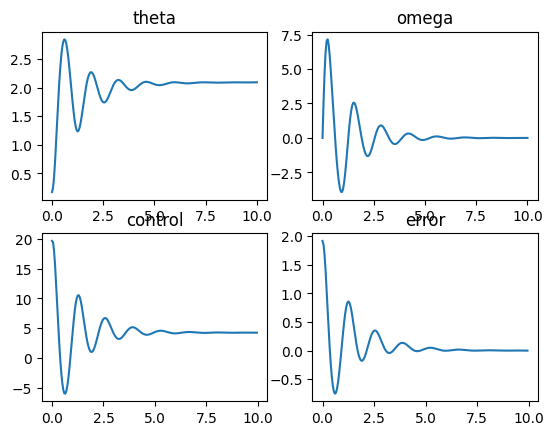

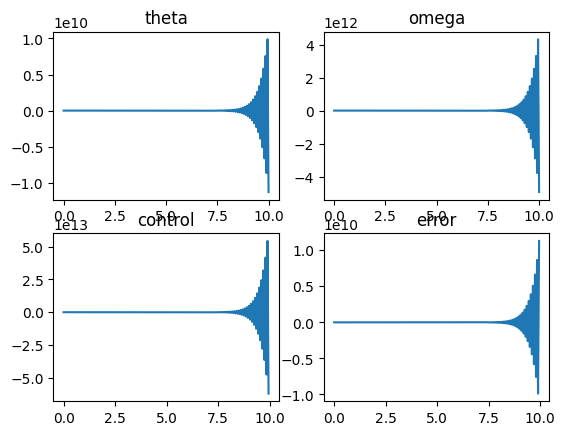

In [109]:
if __name__ == '__main__':
    main()

In [173]:
a = np.array([[1,2],[5,4]])
b = np.array([[1],[0]])
c = np.dot(a,b)
print(c[1,0])
np.append(a,c)
np.zeros((2,3))

5


array([[0., 0., 0.],
       [0., 0., 0.]])

In [47]:
sim_time = 10

sim_dt = 0.05

int(sim_time/sim_dt)

x_array_sf = np.zeros((2,(int(sim_time/sim_dt))))

# a = [[1,2], [5,3], [8, 10]]
# b =[ items[0] for sublist in a for items in sublist] 
# print(b)
for i in np.arange(1,5,1):
    print(i)

1
2
3
4
